In [1]:
from llm.context.llm_context import LLMContext
from llm.strategy.big_llama_model import BigLlamaModel
from llm.strategy.big_llama3_1_model import BigLlama3_1Model
from llm.strategy.small_llama_model import SmallLlamaModel
from llm.strategy.big_mistral_model import BigMistralModel
from llm.strategy.haiku3_model import Haiku3Model
from llm.strategy.sonet3_model import Sonet3Model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from tqdm import tqdm
import os
import numpy as np 
import pandas as pd
import re
import warnings
import spacy

In [2]:
PATH = './data/processed/txt'

In [2]:
!pip3 freeze > requirements.txt

# Functions

In [3]:
def create_folder(name):
    try:
        os.mkdir(name)
        print(f"Folder '{name}' created successfully")
    except FileExistsError:
        pass
    except Exception as e:
        print(f"Error creating the folder '{name}': {e}")

In [4]:
def save_file(filename, text):
    with open(filename, 'w') as archivo:
        archivo.write(text)

In [5]:
def get_text_and_masked_carmen(name):
    filename = f'./data/processed/txt/{name}'
    filename_result = f'./data/processed/masked/{name}'
    with open(filename, 'r') as archivo:
        text = archivo.read()

    with open(filename_result, 'r') as archivo:
        text_masked = archivo.read()

    return [text, text_masked]

In [6]:
def store_metrics(metrics_data, precision, recall, f1, cosine_sim, levenshtein_distance, labels):
    metrics_data["precision"] = precision
    metrics_data["recall"] = recall
    metrics_data["f1"] = f1
    metrics_data["cos"] = cosine_sim
    metrics_data["levenshtein"] = levenshtein_distance
    metrics_data["ground_truth"] = labels[0]
    metrics_data["generated"] = labels[1]
    if int(metrics_data["levenshtein"]) == 0:
        metrics_data["inv_levenshtein"] = 1
    else: 
        metrics_data["inv_levenshtein"] = (1/metrics_data["levenshtein"])
        metrics_data["overall"] = metrics_data["precision"] + metrics_data["recall"] +  metrics_data["f1"] + metrics_data["cos"] + metrics_data["inv_levenshtein"]
    return metrics_data

In [7]:
def save_metrics(name_model, list_data):
    list_data = pd.DataFrame(list_data)
    list_data.to_csv(f'data/metrics/{name_model}.csv')

# Metrics

In [8]:
warnings.filterwarnings("ignore", message="\[W008\] Evaluating Doc.similarity based on empty vectors")
nlp = spacy.load("es_core_news_md")


In [9]:
def embedding_similarity(str1, str2, threshold=0.8):
    doc1 = nlp(str1)
    doc2 = nlp(str2)
    similarity = doc1.similarity(doc2)
    return similarity >= threshold

In [10]:
def eliminar_adverbios_preposiciones_determinantes(texto):
    doc = nlp(texto)
    # Eliminar preposiciones (ADP) y determinantes (DET)
    tokens_filtrados = [token.text for token in doc if token.pos_ not in ('ADP', 'DET')]
    return ' '.join(tokens_filtrados)

In [11]:
def levenshtein_distance(s1, s2, show_progress=True):
    """
    Calcula la distancia de Levenshtein entre dos cadenas.

    La distancia de Levenshtein es el número mínimo de operaciones de edición 
    (inserción, eliminación o sustitución de un carácter) necesarias para 
    transformar una cadena en otra.

    Parámetros:
        s1 (str): Primera cadena
        s2 (str): Segunda cadena
        show_progress (bool): Si es True, muestra una barra de progreso. 
                              Por defecto es False.
    Retorna:
        int: La distancia de Levenshtein entre s1 y s2
    """
    

    # Usar tqdm solo si show_progress es True
    iterable = tqdm(s1) if show_progress else s1

    if len(s1) < len(s2):
        s1, s2 = s2, s1
    if len(s2) == 0:
        return len(s1)

    previous_row = list(range(len(s2) + 1))
    for i, c1 in enumerate(iterable):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

In [12]:
def get_cos_sim(text_hoped, text_generated):
    vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w[\w\-/]*\b")
    tfidf_matrix = vectorizer.fit_transform([text_hoped, text_generated])

    try:
        cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
    except: 
        return 0.0
    return cosine_sim[0][0]

In [13]:
def calc_metrics(ground_truth, predictions):
    # Convertir arrays de ground_truth y predictions a listas de str
    ground_truth_processed = np.array([eliminar_adverbios_preposiciones_determinantes(str(item)) for item in ground_truth])
    predictions_processed = np.array([eliminar_adverbios_preposiciones_determinantes(str(item)) for item in predictions])

    # Crear matrices de similitud de coseno y embedding 
    get_cos_sim_vectorized = np.vectorize(lambda gt, pred: get_cos_sim(str(gt), str(pred)))
    embedding_similarity_vectorized = np.vectorize(lambda gt, pred: embedding_similarity(str(gt), str(pred)))

    cosine_results = get_cos_sim_vectorized(ground_truth_processed[:, None], predictions_processed[None, :])
    embedding_results = embedding_similarity_vectorized(ground_truth_processed[:, None], predictions_processed[None, :])
    
    # Promediar las similitudes
    avg_similarities = (cosine_results + embedding_results) / 2

    # Determinar verdaderos positivos
    matches = avg_similarities > 0.5
    true_positives = np.sum(np.any(matches, axis=1))

    # Determinar falsos negativos
    false_negatives = len(ground_truth) - true_positives

    # Determinar falsos positivos
    predicted_matches = np.any(matches, axis=0)
    false_positives = len(predictions) - np.sum(predicted_matches)

    # Cálculo de métricas
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(precision)
    print(recall)
    print(f1)

    return precision, recall, f1


In [14]:
def evaluate(masked, generated):
    """ 
    Input: 
        - masked (str): Ground_truth text
        - generated(str): Text to be evaluated

    Output:
        - Precision, Recall and F1 (float)
    """
    ground_truth = re.findall(r'\[\*\*(.*?)\*\*\]', masked)
    predictions = re.findall(r'\[\*\*(.*?)\*\*\]', generated)
    labels = [ground_truth, predictions]
    return [calc_metrics(ground_truth, predictions), labels]

In [15]:
def calculate_metrics(text_hoped, text_generated):
    [cal_met, labels] = evaluate(text_hoped, text_generated)
    cosine_sim = get_cos_sim(text_hoped, text_generated)
    text_generated = text_generated.replace('[**', '').replace('**]', '')
    text_hoped = text_hoped.replace('[**', '').replace('**]', '')
    result = levenshtein_distance(text_generated, text_hoped[:len(text_generated)], show_progress=False)
    return cosine_sim, cal_met, result, labels

In [16]:
def partial_score(X, Y):
    if X in Y or Y in X:
        x_words = X.split()
        y_words = Y.split()

        counter_a1 = Counter(x_words)
        counter_a2 = Counter(y_words)

        matches = 0

        for element in counter_a1:
            if element in counter_a2:

                matches += min(counter_a1[element], counter_a2[element])

        return matches / len(x_words) if len(x_words) > 0 else 0
    else:
        return 0
    
def replace_special_characters(text):
    # Define the pattern to match special characters including . / and -
    pattern = r'[!@#$%^&*()_+={}\[\]:;"\'<>,?\\|`~./-]'
    
    # Replace the matched characters with a space
    result = re.sub(pattern, ' ', text)
    
    return result

def evaluate2(masked,generated):
    masked=masked.replace('\n','')
    generated=generated.replace('\n','')

    ground_truth_matches = re.finditer(r'\[\*\*(.*?)\*\*\]', masked)
    ground_truth_positions = {}
    cnt=0
    for match in ground_truth_matches:
        start = match.start(1)-(cnt*2+1)*3  # start of the group (excluding [**)
        end = match.end(1)-(cnt*2+1)*3
        cnt+=1# end of the group (excluding **])
        ground_truth_positions[(start, end)] = replace_special_characters(match.group(1))

    predictions_matches = re.finditer(r'\[\*\*(.*?)\*\*\]', generated)
    predictions_positions = {}
    cnt=0
    for match in predictions_matches:
        start = match.start(1)-(cnt*2+1)*3  # start of the group (excluding [**)
        end = match.end(1)-(cnt*2+1)*3
        cnt+=1# end of the group (excluding **])
        predictions_positions[(start, end)] = replace_special_characters(match.group(1))

    totalwordcnt_ground_truth = len(ground_truth_positions)
    score_total=0
    for pos_g in ground_truth_positions:
        for pos_p in predictions_positions:
            if (pos_p[0]<=pos_g[0] and pos_p[1]>=pos_g[1]) or (pos_p[0]>=pos_g[0] and pos_p[1]<=pos_g[1]):
                score_temp = partial_score(ground_truth_positions[pos_g],predictions_positions[pos_p])
                score_total += score_temp

    score_total = score_total/totalwordcnt_ground_truth
    recall = score_total

    totalwordcnt_predictions = len(predictions_positions)
    score_total=0
    for pos_p in predictions_positions:
        for pos_g in ground_truth_positions:
            if (pos_g[0]<=pos_p[0] and pos_g[1]>=pos_p[1]) or (pos_g[0]>=pos_p[0] and pos_g[1]<=pos_p[1]):
                score_temp = partial_score(predictions_positions[pos_p],ground_truth_positions[pos_g])
                score_total += score_temp

    score_total = score_total/totalwordcnt_predictions
    precision = score_total
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

In [2]:
def compute_classification_agreement(dict1, dict2):
    # Look for key disagreement
    keys_not_present_in_dict2 = list(set(dict1.keys()) - set(dict2.keys()))
    
    # look for misclassifications
    disagreement_in_values = {}
    for key in dict1.keys() & dict2.keys():
        if dict1[key] != dict2[key]:
            disagreement_in_values[key] = (dict1[key], dict2[key])

    return disagreement_in_values, keys_not_present_in_dict2



# Modificacion del un label_dict para usar como ejmeplo
import pandas as pd 
import random 
filename = r'./data/processed/ann/CARMEN-I_CC_1.csv'

# Transform .ann file to dictionary
label_dict = pd.read_csv(filename, header=None)[[0,3]].set_index(3).to_dict()[0]
dict_modificado = label_dict.copy()

# Eliminar una clave al azar
key_to_remove = random.choice(list(dict_modificado.keys()))
del dict_modificado[key_to_remove]

# Seleccionar 3 claves al azar para intercambiar sus valores
keys_to_swap = random.sample(list(dict_modificado.keys()), 3)
val1, val2, val3 = dict_modificado[keys_to_swap[0]], dict_modificado[keys_to_swap[1]], dict_modificado[keys_to_swap[2]]

# Intercambiar valores entre las tres claves
dict_modificado[keys_to_swap[0]] = val2
dict_modificado[keys_to_swap[1]] = val3
dict_modificado[keys_to_swap[2]] = val1


# Ejemplo de uso
print('Ejemplo:')
print(label_dict)
diferencias, unicas_dict1 = compute_classification_agreement(label_dict, dict_modificado)
print("Errores de clasificacion:", diferencias)
print("Claves no enconctradas en el segundo diccionario:", unicas_dict1)


Ejemplo:
Errores de clasificacion: {'Salud laboral': ('OTROS_SUJETO_ASISTENCIA', 'NUMERO_TELEFONO'), '10.09.2021': ('FECHAS', 'OTROS_SUJETO_ASISTENCIA'), '983425634': ('NUMERO_TELEFONO', 'FECHAS')}
Claves no enconctradas en el segundo diccionario: ['suegro']


# Loop

In [17]:
def anonimized(llm=None, name_model="", data=None):
    counter = 0
    context = LLMContext(llm)
    list_data  = []
    for filename in sorted(os.listdir(PATH)):
        print(filename)
        metrics_data = {}
        metrics_data["filename"] = filename
        try:
            [text, text_hoped] = get_text_and_masked_carmen(filename)
            data["user"] = text
            text_generated = context.generate_response(data)
            create_folder(f'data/anon/raw/{name_model}')
            save_file(f'data/anon/raw/{name_model}/{filename}', text_generated)
            cosine_sim, cal_met, result, labels = calculate_metrics(text_hoped, text_generated)
            metrics_data = store_metrics(metrics_data, cal_met[0],cal_met[1], cal_met[2], cosine_sim, result, labels)
            list_data.append(metrics_data)
            counter += 1
            if counter >= 100:
                break
        except Exception as e:
            print(e) 
            metrics_data["fail"] = 1
        finally:
            list_data.append(metrics_data)
    save_metrics(name_model, list_data)
    

# Prompt 1

In [18]:
data = {}
data["system"] = """
You are an anonymization tool in identifying attributes in texts that can identify or quasi-identify a user.
Return only the original text with the identification and labeling of the patient's personal information by adding it between [** and **].
Following are attributes that you must anonymize.

- Names
Example:
En seguimiento por Hematología Centro Médico Aspasia (Dra. Valvanera).   ->
En seguimiento por Hematología [**Centro Médico Aspasia**] (Dra. [**Valvanera**]).

- Ages
Example: 
Varón de 41 años.   ->
[**Varón**] de [**41 años**].

- Sexes
Example: 
Varón de 41 años.   ->
[**Varón**] de [**41 años**].

- Professions
Example: 
Trabaja como profesor.   ->
Trabaja como [**profesor**].

- Relatives
Example: 
Vive con suegro y 2 yernos.   ->
Vive con [**suegro**] y [**2 yernos**].

- Dates
Example: 
ha estado viviendo en el Centro desde septiembre de 2008.   ->
ha estado viviendo en el [**Centro**] desde [**septiembre de 2008**].

- Phone numbers
Example: 
contactando con el siguiente número de teléfono +50 88 078 68 49.   ->
contactando con el siguiente número de teléfono [**+50 88 078 68 49**].

- Identification numbers
Example:
El paciente otorga su consentimiento informado para participar en el estudio del protocolo WYX/8408/5545.   ->
El paciente otorga su consentimiento informado para participar en el estudio del protocolo [**WYX/8408/5545.**]

- Institutions, hospitals, health centers, etc
Example: 
En seguimiento por Hematología Centro Médico Aspasia (Dra. Valvanera).   ->
En seguimiento por Hematología [**Centro Médico Aspasia**] (Dra. [**Valvanera**]).
Example:
Control en Centro Salud Mental Reyes Católicos.   ->
Control en [**Centro Salud Mental Reyes Católicos**].

- Countries, territories, streets, etc
Example:
nacido en la República Italiana.   ->
nacido en la [**República Italiana**].
Example:
ha estado viviendo en el Centro desde septiembre de 2008.   ->
ha estado viviendo en el [**Centro**] desde [**septiembre de 2008**].
Example:
la dirección es Calle de Victor Hugo 39.   ->
la dirección es [**Calle de Victor Hugo 39**].

- Website URLs
participar a través del siguiente enlace: https://www.donarsang.gencat.cat/covid19.   ->
participar a través del siguiente enlace: [**https://www.donarsang.gencat.cat/covid19**].

- Drugs -
Does not include drugs on anonymization
Example: 
Omeprazol 20 mg/24h, fluticasona 50mcg/salmeterol 500mcg/12h -> 
Omeprazol 20 mg/24h, fluticasona 50mcg/salmeterol 500mcg/12h


- Other sensitive information such as races, ethnicities, sexual orientation, dietary preferences, etc
Example:
raça blanca   ->
[**raça blanca**]
Example:
Hsh
[**Hsh**]
Example:
Vegetarià
[**Vegetarià**]


Do not comment anything else.
Besides the anonymized attributes, provide the rest of the text exactly the same, including special characters and \n symbols.
Do not correct any typos or spacing errors at your discretion.
For example, if the time is written as 31/12/2000-0 9:20:00 with incorrect spacing, do not return it corrected as 31/12/2000-09:20:00.
Also, for example, if FLUTICASONA + AZELA STINA4 is written with incorrect spacing, do not return it corrected as FLUTICASONA + AZELASTINA 4.
Only focus on the anonymization tasks I have specified, and ignore any typos or spacing errors
"""

In [19]:
len(data["system"])

3262

In [20]:
# anonimized(llm=Sonet3Model(), name_model="sonet3", data=data)
# anonimized(llm=Haiku3Model(), name_model="haiku3", data=data)

In [21]:
haiku3_data = pd.read_csv('./data/metrics/haiku3.csv')
haiku3_data = haiku3_data[haiku3_data['fail'] != 0]
print(haiku3_data.shape)
print(haiku3_data["precision"].mean())
print(haiku3_data["recall"].mean())
print(haiku3_data["f1"].mean())
print(haiku3_data["cos"].mean())
print(haiku3_data['levenshtein'].mean())
print(haiku3_data['inv_levenshtein'].mean())
print(haiku3_data['overall'].mean())

(201, 12)
0.5149565578551344
0.8662432096923663
0.6051813033233288
0.9926035614686615
5.22
0.499389044384734
3.334622858268047


In [22]:
sonet3_data = pd.read_csv('./data/metrics/sonet3.csv')
sonet3_data = sonet3_data[sonet3_data['fail'] != 0]
print(sonet3_data["precision"].mean())
print(sonet3_data["recall"].mean())
print(sonet3_data["f1"].mean())
print(sonet3_data["cos"].mean())
print(sonet3_data['levenshtein'].mean())
print(sonet3_data['inv_levenshtein'].mean())
print(sonet3_data['overall'].mean())

0.771130685141101
0.8637395815367964
0.7971793813441076
0.9980584983988646
4.72
0.5568777451450805
3.8291187711441372


In [23]:
# anonimized(llm=BigLlamaModel(), name_model="big_llama3", data=data)

In [24]:
big_llama_data = pd.read_csv('./data/metrics/big_llama3.csv')
print(big_llama_data.shape)
print(big_llama_data["precision"].mean())
print(big_llama_data["recall"].mean())
print(big_llama_data["f1"].mean())
print(big_llama_data["cos"].mean())
print(big_llama_data['levenshtein'].mean())
print(big_llama_data['inv_levenshtein'].mean())
print(big_llama_data['overall'].mean())

(200, 11)
0.6813861500207861
0.862360347729612
0.7293225022963162
0.9968518990471088
8.55
0.5018324559038845
3.7717533549977076


In [25]:
# anonimized(llm=SmallLlamaModel(), name_model="small_llama3", data=data)

In [26]:
small_llama = pd.read_csv('./data/metrics/small_llama3.csv')
small_llama = small_llama[small_llama['fail'] != 0]
print(small_llama.shape)
print(small_llama["precision"].mean())
print(small_llama["recall"].mean())
print(small_llama["f1"].mean())
print(small_llama["cos"].mean())
print(small_llama['levenshtein'].mean())
print(small_llama['inv_levenshtein'].mean())
print(small_llama['overall'].mean())

(220, 12)
0.35647973459698223
0.5780418546535994
0.39271663554292874
0.9910574538871632
24.41
0.37034628812668274
2.6886419668073565


In [27]:
# anonimized(llm=BigMistralModel(), name_model="big_mistral", data=data)

In [28]:
mistral = pd.read_csv('./data/metrics/big_mistral.csv')
print(mistral.shape)
print(mistral["precision"].mean())
print(mistral["recall"].mean())
print(mistral["f1"].mean())
print(mistral["cos"].mean())
print(mistral['levenshtein'].mean())
print(mistral['inv_levenshtein'].mean())
print(mistral['overall'].mean())

(202, 12)
0.6047592555707106
0.4756985196536956
0.4682127617200233
0.9796671029865229
24.51
0.5461363453517354
3.074473985282688


In [29]:
#anonimized(llm=BigLlama3_1Model(), name_model="BigLlama3_1Model", data=data)

In [30]:
BigLlama3_1Model = pd.read_csv('./data/metrics/BigLlama3_1Model.csv')
BigLlama3_1Model = BigLlama3_1Model[BigLlama3_1Model['fail'] != 0]
print(BigLlama3_1Model.shape)
print(BigLlama3_1Model["precision"].mean())
print(BigLlama3_1Model["recall"].mean())
print(BigLlama3_1Model["f1"].mean())
print(BigLlama3_1Model["cos"].mean())
print(BigLlama3_1Model['levenshtein'].mean())
print(BigLlama3_1Model['inv_levenshtein'].mean())
print(BigLlama3_1Model['overall'].mean())

(231, 12)
0.8972680765675449
0.9445218074838819
0.9141201245585546
0.9983652007630383
1.7
0.8459583333333334
4.600233542706353


In [31]:
from llm.strategy.sonet3_5_model import Sonet3_5Model

anonimized(llm=Sonet3_5Model(), name_model="Sonet3_5Model", data=data)

CARMEN-I_CC_1.txt
Folder 'data/anon/raw/Sonet3_5Model' created successfully
1.0
0.9375
0.967741935483871
CARMEN-I_CC_2.txt
0.9523809523809523
1.0
0.975609756097561
CARMEN-I_CC_3.txt
0.6
1.0
0.7499999999999999
CARMEN-I_CC_4.txt
1.0
0.9473684210526315
0.972972972972973
CARMEN-I_CC_5.txt
1.0
1.0
1.0
CARMEN-I_IA_ANTECEDENTES_1.txt
0.8823529411764706
0.9375
0.9090909090909091
CARMEN-I_IA_ANTECEDENTES_10.txt
0.7777777777777778
1.0
0.8750000000000001
CARMEN-I_IA_ANTECEDENTES_100.txt
0.8333333333333334
0.9090909090909091
0.8695652173913043
CARMEN-I_IA_ANTECEDENTES_101.txt
empty vocabulary; perhaps the documents only contain stop words
CARMEN-I_IA_ANTECEDENTES_102.txt
0.9583333333333334
0.92
0.9387755102040817
CARMEN-I_IA_ANTECEDENTES_103.txt
0.6666666666666666
0.8571428571428571
0.75
CARMEN-I_IA_ANTECEDENTES_104.txt
1.0
1.0
1.0
CARMEN-I_IA_ANTECEDENTES_105.txt
1.0
1.0
1.0
CARMEN-I_IA_ANTECEDENTES_106.txt
0.875
1.0
0.9333333333333333
CARMEN-I_IA_ANTECEDENTES_107.txt
1.0
1.0
1.0
CARMEN-I_IA_ANTE

In [32]:
from llm.strategy.opus3_model import OpusModel

anonimized(llm=OpusModel(), name_model="OpusModel", data=data)

CARMEN-I_CC_1.txt
Folder 'data/anon/raw/OpusModel' created successfully
1.0
0.9375
0.967741935483871
CARMEN-I_CC_2.txt
0.8333333333333334
1.0
0.9090909090909091
CARMEN-I_CC_3.txt
0.75
1.0
0.8571428571428571
CARMEN-I_CC_4.txt
0.68
0.8947368421052632
0.7727272727272727
CARMEN-I_CC_5.txt
0.7666666666666667
1.0
0.8679245283018869
CARMEN-I_IA_ANTECEDENTES_1.txt
0.7894736842105263
0.9375
0.8571428571428572
CARMEN-I_IA_ANTECEDENTES_10.txt
1.0
1.0
1.0
CARMEN-I_IA_ANTECEDENTES_100.txt
0.85
0.7727272727272727
0.8095238095238095
CARMEN-I_IA_ANTECEDENTES_101.txt
empty vocabulary; perhaps the documents only contain stop words
CARMEN-I_IA_ANTECEDENTES_102.txt
0.8461538461538461
0.88
0.8627450980392156
CARMEN-I_IA_ANTECEDENTES_103.txt
0.6666666666666666
0.8571428571428571
0.75
CARMEN-I_IA_ANTECEDENTES_104.txt
1.0
1.0
1.0
CARMEN-I_IA_ANTECEDENTES_105.txt
1.0
1.0
1.0
CARMEN-I_IA_ANTECEDENTES_106.txt
1.0
1.0
1.0
CARMEN-I_IA_ANTECEDENTES_107.txt
1.0
1.0
1.0
CARMEN-I_IA_ANTECEDENTES_108.txt
0.5
1.0
0.6666

In [ ]:
from llm.context.llm_context import LLMContext
from llm.strategy.big_llama_model import BigLlamaModel
from llm.strategy.haiku3_model import Haiku3Model

# Big Llama
data = {"system": "Lorem ipsum test", "user": "Lorem ipsum text"}
context = LLMContext(BigLlamaModel())
text_generated = context.generate_response(data)

# Haiku
data = {"system": "Lorem ipsum", "user": "Lorem ipsum"}
context = LLMContext(Haiku3Model())
text_generated = context.generate_response(data)


In [34]:
Sonet3_5_data = pd.read_csv('./data/metrics/Sonet3_5Model.csv')
Sonet3_5_data = Sonet3_5_data[Sonet3_5_data['fail'] != 0]
print(Sonet3_5_data.shape)
print(Sonet3_5_data["precision"].mean())
print(Sonet3_5_data["recall"].mean())
print(Sonet3_5_data["f1"].mean())
print(Sonet3_5_data["cos"].mean())
print(Sonet3_5_data['levenshtein'].mean())
print(Sonet3_5_data['inv_levenshtein'].mean())
print(Sonet3_5_data['overall'].mean())

(201, 12)
0.8535672483191294
0.9627737779670088
0.8985131509758659
0.9994267983558274
1.99
0.651120879120879
4.204708143475926


In [35]:
OpusModel_data = pd.read_csv('./data/metrics/OpusModel.csv')
OpusModel_data = OpusModel_data[OpusModel_data['fail'] != 0]
print(OpusModel_data.shape)
print(OpusModel_data["precision"].mean())
print(OpusModel_data["recall"].mean())
print(OpusModel_data["f1"].mean())
print(OpusModel_data["cos"].mean())
print(OpusModel_data['levenshtein'].mean())
print(OpusModel_data['inv_levenshtein'].mean())
print(OpusModel_data['overall'].mean())

(205, 12)
0.844970460044348
0.9586331207621069
0.8880016797900169
0.991238482578299
26.88
0.4865013165808512
3.904609461724178


## Visualization

In [178]:
from tqdm import tqdm 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def visualization_label_classification(file):
    df = pd.read_csv(file, index_col=0)

    y_true = []
    y_pred = []

    for i in range(len(df)):
        row = df.iloc[i]

        data = {
            'real' : eval(row.real), 
            'predicted' : eval(row.predicted), 
            'fail': eval(row.fails), 
            'miss': eval(row.miss)
        }

        # Add correctly classified words
        for key in data['real']:
            if key in data['predicted'].keys():
                y_true.append(data['real'][key])
                y_pred.append(data['real'][key])

        # Add incorrectly classified words
        for key in data['fail']:
            y_true.append(data['fail'][key][0])
            y_pred.append(data['fail'][key][1])


        for word in data['miss']:
            y_true.append(data['real'][word])
            y_pred.append('missing')

    categories = list(set(y_pred+y_true))

    
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_true, y_pred, labels=categories, normalize='true')

    # Convertir la matriz en un DataFrame
    conf_matrix_df = pd.DataFrame(conf_matrix, index=categories, columns=categories)

    # Eliminar la fila "missing" (si existe) del DataFrame
    if 'missing' in conf_matrix_df.index:
        conf_matrix_df = conf_matrix_df.drop('missing', axis=0)


    # Ajustar la visualización
    plt.figure(figsize=(15, 13))
    sns.heatmap(conf_matrix_df, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, linecolor='gray', square=True, cbar=True, cbar_kws={'shrink': 0.75})

    # Títulos y etiquetas
    plt.title('Relationship Between Real and Predicted Categories', fontsize=18, pad=20)
    plt.xlabel('Predicted Categories', fontsize=14)
    plt.ylabel('Real Categories', fontsize=14)

    # Ajustes estéticos adicionales
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)

    # Mostrar la gráfica
    plt.show()

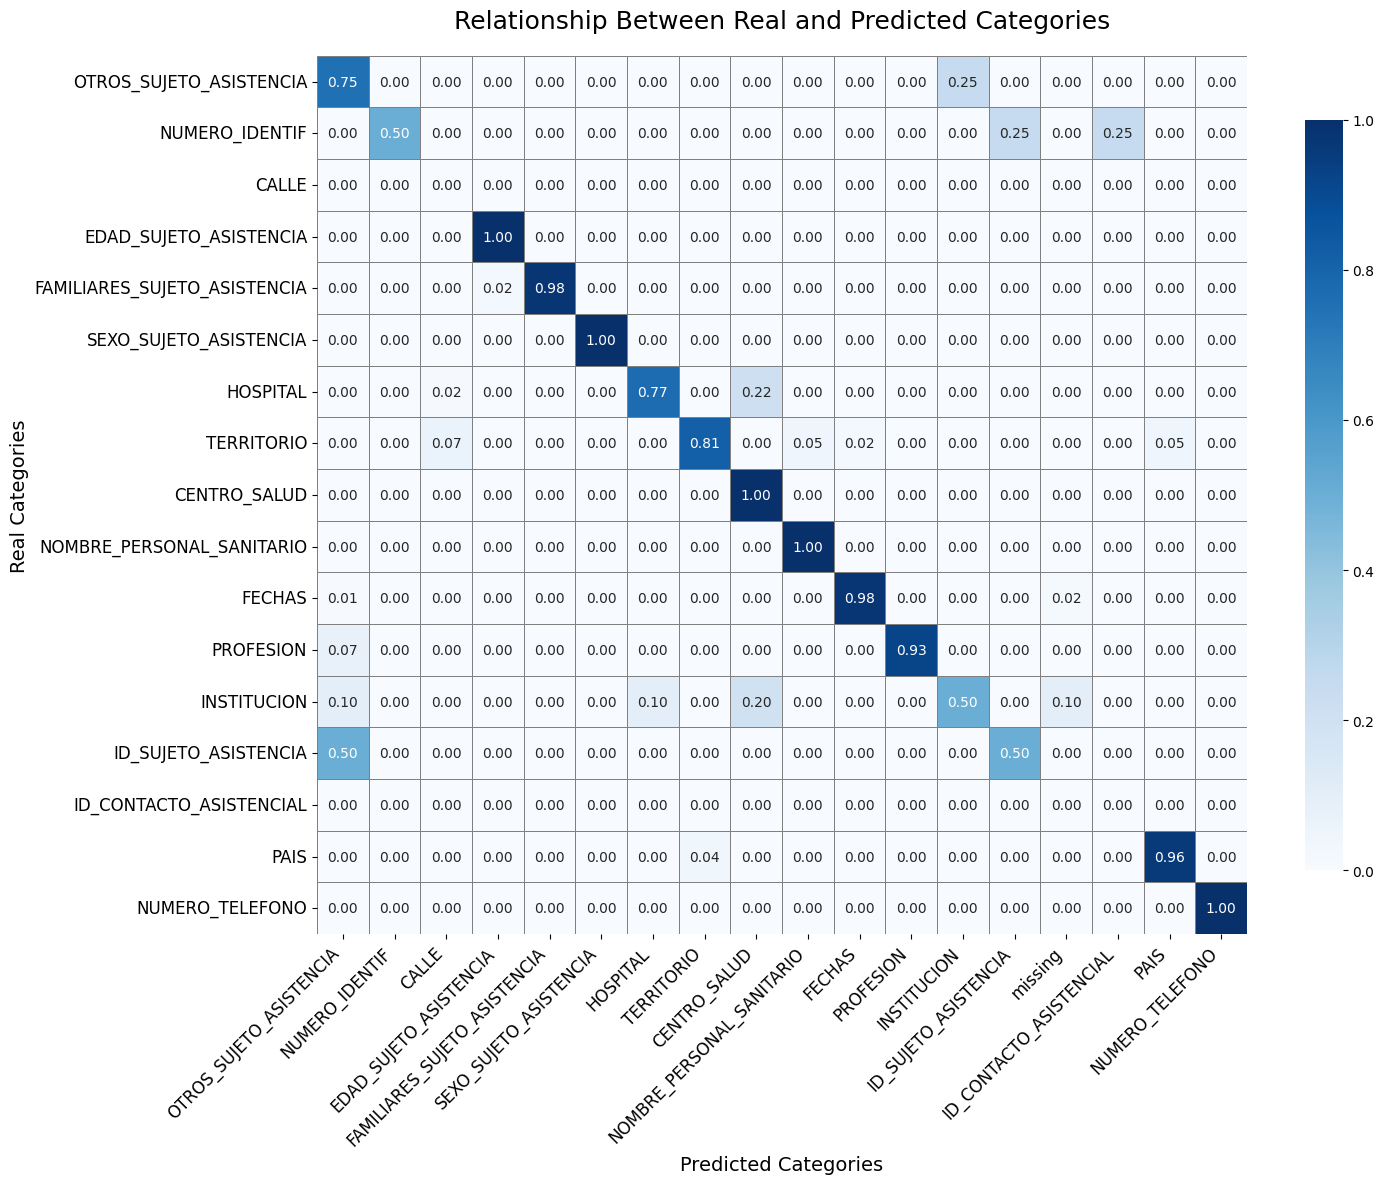

In [179]:
visualization_label_classification('big_llama3_1.csv')